In [16]:
import os
import sys
import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import warnings
warnings.filterwarnings("ignore")

In [17]:
df_full = pd.read_csv('../input/file-format-detection/dataset.csv')

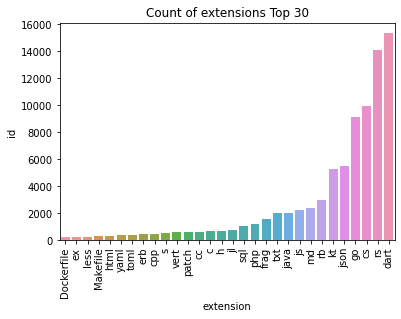

In [18]:
df_ext_count = df_full.groupby('extension').count().sort_values(by='id')

plt.xticks(rotation=90)
plt.title('Count of extensions Top 30')
sns.barplot(x=df_ext_count.index[-30:], y=df_ext_count['id'][-30:])
plt.show()

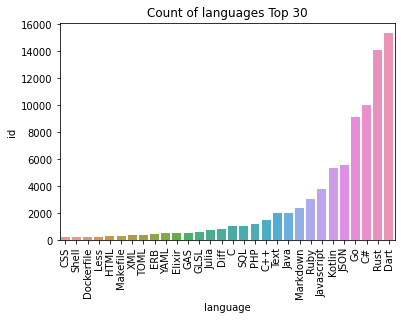

In [19]:
df_lang_count = df_full.groupby('language').count().sort_values(by='id')

plt.xticks(rotation=90)
plt.title('Count of languages Top 30')
sns.barplot(x=df_lang_count.index[-30:], y=df_lang_count['id'][-30:])
plt.show()

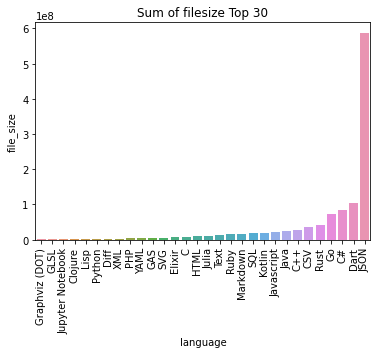

In [20]:
df_filesizes = df_full.groupby('language').sum().sort_values(by='file_size')

plt.xticks(rotation=90)
plt.title('Sum of filesize Top 30')
sns.barplot(x=df_filesizes.index[-30:], y=df_filesizes['file_size'][-30:])
plt.show()

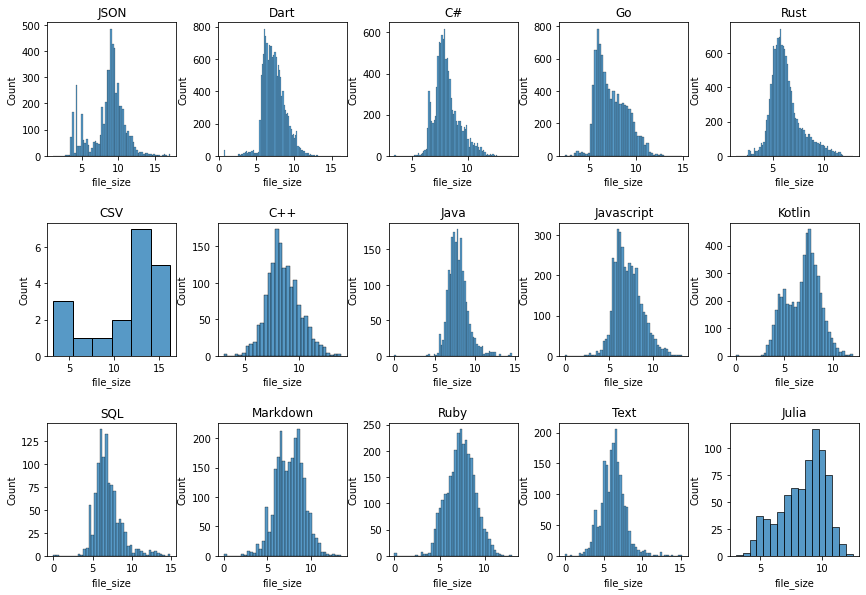

In [21]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
langs = list(df_filesizes.index[-15:])[::-1]

for i, lang in enumerate(langs):
    if i >= axes.shape[0] * axes.shape[1]: break
    r, c = i // 5, i % 5
    axes[r][c].set_title(lang)
    sns.histplot(df_full[df_full.language == lang]['file_size'].apply(np.log1p), ax=axes[r][c])

plt.show()

In [23]:
languages = list(df_lang_count[df_lang_count > 500].dropna().index)
num_cls = len(languages)
print('Train and predict for only:', languages)

Train and predict for only: ['YAML', 'Elixir', 'GAS', 'GLSL', 'Julia', 'Diff', 'C', 'SQL', 'PHP', 'C++', 'Text', 'Java', 'Markdown', 'Ruby', 'Javascript', 'Kotlin', 'JSON', 'Go', 'C#', 'Rust', 'Dart']


In [24]:
def get_content(file_path):
    path = os.path.join('../input/file-format-detection/dataset', file_path)
    encodings = ['utf-8', 'cp949']
    for enc in encodings:
        try:
            f = open(path, 'r', encoding=enc)
            ret = '\n'.join(list(map(lambda s: s.rstrip(), f.readlines())))
            f.close()
            return ret
        except UnicodeDecodeError:
            continue
        except:
            break
        finally:
            if f != None: f.close()
    return None

def add_file_content(df):
    contents = []
    for i, row in tqdm_nb(df.iterrows(), total=len(df), desc='read files'):
        contents.append(get_content(row['file_path']))
    df['file_content'] = contents
    return df

In [25]:
df = add_file_content(df_full[df_full.language.isin(languages)].sample(frac=0.5))
# print('List by failed to read contents:\n', df[df['file_content'].isna()][['file_path', 'language', 'file_size']])
df = df.dropna()
df

read files:   0%|          | 0/40773 [00:00<?, ?it/s]

,id,file_path,file_size,line_count,extension,language,file_content
45394,45395,Go/045395.go,554,40,go,Go,// compile\n\n// Copyright 2021 The Go Authors...
42915,42916,C/042916.c,1811,60,c,C,#include <stdio.h>\n#include <windows.h>\n#inc...
26523,26524,Dart/026524.dart,412,19,dart,Dart,"// Copyright (c) 2017, the Dart project author..."
20002,20003,Dart/020003.dart,23717,1115,dart,Dart,"// Copyright (c) 2019, the Dart project author..."
82197,82198,Rust/082198.rs,658,33,rs,Rust,"// run-pass (note: this is spec-UB, but it wor..."
...,...,...,...,...,...,...,...
74362,74363,Rust/074363.rs,455,23,rs,Rust,#![feature(negative_impls)]\n// edition:2018\n...
85646,85648,SQL/085648.sql,2503,80,sql,SQL,USE MASTER\n\n-- show memory DMVs\n/*\nSELECT ...
12785,12786,JSON/012786.json,8576,150,json,JSON,"﻿{\n ""Entries"": [\n {\n ""RequestUri"":..."
32157,32158,Dart/032158.dart,1571,49,dart,Dart,"// Copyright (c) 2011, the Dart project author..."


In [26]:
# Define functions to remove comments for each specific language
import re

# C++ comment removal function
def remove_cpp_comments(paragraph):
    return re.sub(r'//.*', '', paragraph)


# Python comment removal function
def remove_python_comments(paragraph):
    return re.sub(r'#.*', '', paragraph)

# C comment removal function
def remove_c_comments(paragraph):
    return re.sub(r'\/\[\s\S]?\\/|\/\/.', '', paragraph)

# SQL comment removal function
def remove_sql_comments(paragraph):
    return re.sub(r'--.*', '', paragraph)

# Java comment removal function
def remove_java_comments(paragraph):
    return re.sub(r'//.*', '', paragraph)


# PHP comment removal function
def remove_php_comments(paragraph):
    return re.sub(r'\/\/.|\/\[\s\S]?\\/', '', paragraph)

# Ruby comment removal function
def remove_ruby_comments(paragraph):
    return re.sub(r'#.*', '', paragraph)

# Julia comment removal function
def remove_julia_comments(paragraph):
    return re.sub(r'#.*', '', paragraph)

# Javascript comment removal function
def remove_javascript_comments(paragraph):
    return re.sub(r'\/\/.*', '', paragraph)

# Go comment removal function
def remove_go_comments(paragraph):
    return re.sub(r'\/\/.*', '', paragraph)

# Rust comment removal function
def remove_rust_comments(paragraph):
    return re.sub(r'\/\/.*', '', paragraph)


# Mapping of languages to their corresponding comment removal functions
comment_removal_functions = {
    'YAML': lambda paragraph: re.sub(r'#.*', '', paragraph),
    'Elixir': lambda paragraph: re.sub(r'#.*', '', paragraph),
    'GAS': lambda paragraph: re.sub(r';.*', '', paragraph),
    'GLSL': lambda paragraph: re.sub(r'\/\/.*', '', paragraph),
    'Diff': lambda paragraph: re.sub(r'#.*', '', paragraph),
    'Text': lambda paragraph: paragraph,
    'Markdown': lambda paragraph: paragraph,
    'Kotlin': remove_cpp_comments,  # Assuming similar to C++
    'JSON': lambda paragraph: paragraph,
    'C#': lambda paragraph: re.sub(r'\/\/.*', '', paragraph),  # Similar to C++
    'Dart': lambda paragraph: re.sub(r'\/\/.*', '', paragraph),  # Similar to C++
    'C++': remove_cpp_comments,
    'Python': remove_python_comments,
    'C': remove_c_comments,
    'SQL': remove_sql_comments,
    'Java': remove_java_comments,
    'PHP': remove_php_comments,
    'Ruby': remove_ruby_comments,
    'Julia': remove_julia_comments,
    'Javascript': remove_javascript_comments,
    'Go': remove_go_comments,
    'Rust': remove_rust_comments
}


# Apply the appropriate comment removal function based on the language
def remove_comments(row):
    language = row['language']
    if language in comment_removal_functions:
        return comment_removal_functions[language](row['file_content'])
    else:
        return row['file_content']

# Apply the function to each row of the DataFrame and update the 'code_paragraphs' column
df['file_content'] = df.apply(remove_comments, axis=1)

# Output the cleaned code paragraphs
print(df['file_content'])

45394    \n\n\n\n\n\npackage main\n\nimport (\n\t"fmt"\...
42915    #include <stdio.h>\n#include <windows.h>\n#inc...
26523    \n\n\n\n/*@testedFeatures=checks*/\nlibrary te...
20002    \n\n\n\nimport 'package:analyzer/dart/ast/ast....
82197    \n#![allow(dead_code)]\n\n\n#[repr(packed)]\ns...
                               ...                        
74362    #![feature(negative_impls)]\n\n\n\n\n\nstruct ...
85646    USE MASTER\n\n\n/*\nSELECT name\nFROM sys.syst...
12785    ﻿{\n  "Entries": [\n    {\n      "RequestUri":...
32157    \n\n\n\n\n\nimport "package:expect/expect.dart...
6748     \n\n\n\n\n#nullable disable\n\nusing System.Te...
Name: file_content, Length: 40763, dtype: object


# Transformers

In [27]:
X = df['file_content']
y = df['language']
len(X),len(y)

(40763, 40763)

In [2]:
code_snippets = [
    {
        "language": "C++",
        "code": """
#include <iostream>
using namespace std;

class Rectangle {
    private:
        int length;
        int width;
    
    public:
        Rectangle(int l, int w) {
            length = l;
            width = w;
        }

        int area() {
            return length * width;
        }
};

int main() {
    Rectangle rect(5, 4);
    cout << "Area of rectangle: " << rect.area() << endl;
    return 0;
}
""",
        "class": "Rectangle"
    },
    {
        "language": "C",
        "code": """
#include <stdio.h>

struct Rectangle {
    int length;
    int width;
};

int area(struct Rectangle r) {
    return r.length * r.width;
}

int main() {
    struct Rectangle rect = {5, 4};
    printf("Area of rectangle: %d\n", area(rect));
    return 0;
}
""",
        "class": "Rectangle"
    },
    {
        "language": "Dart",
        "code": """class Rectangle {
  int width;
  int height;

  Rectangle(this.width, this.height);

  int get area {
    return width * height;
  }
}

void main() {
  var myRectangle = Rectangle(3, 4);
  print('The area of myRectangle is ${myRectangle.area}');
}

""",
        "class": "Rectangle"
    },
    {
        "language": "Javascript",
        "code": """
class Rectangle {
    constructor(length, width) {
        this.length = length;
        this.width = width;
    }

    area() {
        return this.length * this.width;
    }
}

let rect = new Rectangle(5, 4);
console.log("Area of rectangle:", rect.area());
""",
        "class": "Rectangle"
    },{
        "language": "Rust",
        "code":'''
    // Define a function that calculates the area of a rectangle using tuples
        fn area(width: f64, height: f64) -> f64 {
            width * height // Calculate the area by multiplying the width and height
        }

        fn main() {
            let width1 = 5.0;
            let height1 = 10.0;
            // Call the 'area' function with separate width and height variables
            let area_of_rect1 = area(width1, height1);
            // Print the calculated area
            println!("The area of the rectangle is {} square units.", area_of_rect1);
        }
    '''
    }
]


custom_X=[]
custom_y=[]
for snippet in code_snippets:
    print("Language:", snippet["language"])
    custom_X.append(snippet['code'])
#     print("Class:", snippet["class"])
#     print("Code:")
#     print(snippet["code"])
    custom_y.append(snippet['language'])
    print("=" * 50)



Language: C++
Language: C
Language: Dart
Language: Javascript
Language: Rust


In [29]:
# Convert categories to numerical labels
label_map = {label: idx for idx, label in enumerate(set(y))}
y_ = np.array([label_map[label] for label in y])
custom_y_ =np.array([label_map[label] for label in custom_y])

In [30]:
import torch
seed = 7777
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
import torch.nn as nn
import torch.optim as optim

In [31]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Assuming X is your feature set and y are your labels
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y_.tolist(), test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)



Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert our tokenized data into a torch Dataset
train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_cls)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)




Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Print the evaluation metrics
print(eval_results)

***** Running training *****
  Num examples = 32610
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3060
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
500,1.108500
1000,0.089400
1500,0.038300
2000,0.030300
2500,0.016100
3000,0.012500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

{'eval_loss': 0.02678295224905014, 'eval_runtime': 133.1408, 'eval_samples_per_second': 61.236, 'eval_steps_per_second': 0.481, 'epoch': 3.0}


In [34]:
# Save the model
model.save_pretrained('./saved_model')

# Load the saved model
loaded_model = BertForSequenceClassification.from_pretrained('./saved_model')

# Create a new trainer with the loaded model
new_trainer = Trainer(
    model=loaded_model,
    args=training_args,
)


custom_encodings = tokenizer(custom_X, truncation=True, padding=True)

# Convert into a torch Dataset
custom_dataset = Dataset(custom_encodings, custom_y_)  # dummy labels

# Make predictions with the loaded model
predictions = new_trainer.predict(custom_dataset)

# The predictions are in the logits format. We need to convert logits to class labels.
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=-1)

print(predicted_labels)


Configuration saved in ./saved_model/config.json
Model weights saved in ./saved_model/pytorch_model.bin
loading configuration file ./saved_model/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {

tensor([ 8,  0, 12, 10])


In [ ]:
ind_to_label={}
j=0;
for i in label_map:
    ind_to_label[j]=i
    j+=1

In [3]:
pred =[]
for i in predicted_labels:
    pred.append(ind_to_label[int(i)])
print("Predicted",pred)
print("Actual",custom_y)

Predicted ['C++', 'C', 'Dart', 'Javascript','Rust']
Actual ['C++', 'C', 'Dart', 'Javascript','Rust']


In [38]:
# Save the model
model.save_pretrained('./saved_model')

# Load the saved model
loaded_model = BertForSequenceClassification.from_pretrained('./saved_model')

# Create a new trainer with the loaded model
new_trainer = Trainer(
    model=loaded_model,
    args=training_args,
)

predictions = new_trainer.predict(test_dataset)

# The predictions are in the logits format. We need to convert logits to class labels.
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=-1)


Configuration saved in ./saved_model/config.json
Model weights saved in ./saved_model/pytorch_model.bin
loading configuration file ./saved_model/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {

In [39]:
from sklearn.metrics import classification_report

# Assuming y_true is your list of true labels and y_pred is your list of predicted labels
y_true = y_test  # replace with your actual data
y_pred = predicted_labels.tolist()  # convert tensor to list

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93       101
           1       0.98      0.99      0.99       226
           2       1.00      1.00      1.00       890
           3       1.00      0.99      0.99       517
           4       1.00      1.00      1.00       114
           5       1.00      0.98      0.99        63
           6       0.99      1.00      0.99      1495
           7       1.00      1.00      1.00       143
           8       0.94      0.97      0.96       153
           9       1.00      1.00      1.00        47
          10       0.98      0.99      0.99       386
          11       0.98      0.97      0.97       201
          12       1.00      0.99      1.00      1522
          13       1.00      1.00      1.00       964
          14       1.00      1.00      1.00       201
          15       0.99      0.99      0.99        72
          16       1.00      1.00      1.00       555
          17       1.00    